# Classification with Convolutional Neural Net (CIFAR10)

- CIFAR10 data set을 이용해 plane, car, bird, cat 등의 이미지를 분류하는 문제를 풀어보도록 하겠습니다.

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [8]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.4.1
True


In [0]:
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [0]:
# torch.device()를 통해 gpu를 이용합니다. 
# cuda:뒤의 번호는 gpu를 여러개 동시 사용할 때 쓰이는 gpu 번호입니다.
# gpu 사용이 가능한 경우 torch.cuda.is_available() = True이고 아닌 경우 False가 됩니다.

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load Data & Preprocessing

In [11]:
# 우선 dataset을 불러와 정규화를 해야 합니다.

# torchvision.transforms.Compose() 여러개의 transform을 구성합니다.
# totensor, normalize를 구성합니다.
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

# trainset
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)

# testset
testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False, 
                                       download=True, 
                                       transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# num_workers는 사용하는 cpu의 갯수를 뜻합니다. batch_size = 4입니다.

trainloader = torch.utils.data.DataLoader(trainset,batch_size = 4,shuffle = True)

testloader = torch.utils.data.DataLoader(testset,batch_size=4, shuffle = False)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

  dog  deer  bird   dog


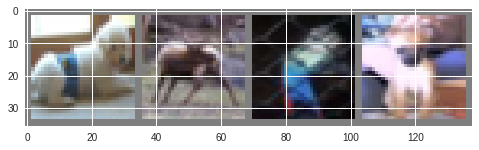

In [13]:
# 우리가 분류하는 image 예시를 한번 보고 가겠습니다.

import matplotlib.pyplot as plt
import numpy as np

# image show 함수
# torchvision.utils.make_grid(images) 는 -1 ~ 1의 범위를 갖습니다. 
# plot을 그리기 위해 우선 0~1 범위로 변경합니다.
# numpy()로 넣어주고 가로로 4개의 이미지를 보여주기 위해 transpose로 차원 위치를 변경합니다.

def imshow(img):
    img = img / 2 +0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

# 학습용 이미지를 iter()로 하나씩 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

#정답 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#이미지 보여주기
imshow(torchvision.utils.make_grid(images))

In [14]:
torchvision.utils.make_grid(images).shape

torch.Size([3, 36, 138])

## Modeling

In [0]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        
        # 이제 3채널 이미지를 처리합니다.
        # 32x32x3xbatch_size
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,6,kernel_size = 5, stride = 1, padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
            )
        # 14x14x6xbatch_size
        self.layer2 = nn.Sequential(
            nn.Conv2d(6,16, kernel_size = 5, stride = 1, padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
            )
        # 5x5x16xbatch_size
        
        self.fc1 = nn.Sequential(
                            nn.Linear(5*5*16,120),
                            nn.ReLU()
                            )
        
        self.fc2 = nn.Sequential(
                            nn.Linear(120,84),
                            nn.ReLU()
                            )
        
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, x):
        
        # conv1(), 32x32인데 kernel_size= 5x5, stride =1, padding =0이므로 output은 28x28x6입니다.
        # pool(), 28x28를 kernel_size = 2x2, stride = 2로 pooling합니다. output은 14x14x6입니다.
        
        x = self.layer1(x)
        
        # conv2(), 14x14x6, kernel_size = 5x5, stride=1, padding = 0이므로 output은 10x10x16이 됩니다.
        # pool(), 10x10를 kernel_size = 2x2, stride =2로 pooling합니다. output은 5x5x16입니다.

        x = self.layer2(x)
        
        x = x.reshape(x.size(0),-1)
 
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x


net = ConvNet()

if torch.cuda.is_available():    
  net = ConvNet().to(device)

## Loss function & Optimizer

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001,momentum=0.9)

## Training

In [17]:
for epoch in range(2): #데이터셋을 여러번 반복합니다.
    
    running_loss = 0.0
    for i, (images,labels) in enumerate(trainloader): 
        
        # 입력을 받습니다.
        
        if torch.cuda.is_available():
          images = images.to(device)
          labels = labels.to(device)
        
        # Feed forward
        
        outputs = net(images)
        loss = criterion(outputs, labels)
        
        # Back prop and update weight
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # loss 출력
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i+1, running_loss/2000))
            running_loss =0.0
            
print("Finished Training")

[1,  2000] loss: 2.219
[1,  4000] loss: 1.914
[1,  6000] loss: 1.698
[1,  8000] loss: 1.601
[1, 10000] loss: 1.541
[1, 12000] loss: 1.492
[2,  2000] loss: 1.415
[2,  4000] loss: 1.392
[2,  6000] loss: 1.369
[2,  8000] loss: 1.348
[2, 10000] loss: 1.323
[2, 12000] loss: 1.281
Finished Training


##  Evaluation

GroundTruth:   cat  ship  ship plane


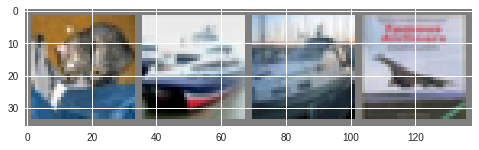

In [18]:
dataiter = iter(testloader) # iter, next를 이용해 test data 하나씩 꺼내옵니다.
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join('%5s' % classes[labels[j]] for j in range(4))) # 시험용 데이터 4개를 출력합니다.

In [20]:
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for images, labels in testloader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.long()).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct/total))

# 전체 데이터 셋에 대해서는 55%의 정확도를 보여줍니다.

Accuracy of the network on the 10000 test images: 55 %


In [21]:
class_correct = list(0. for i in range(10)) #빈 리스트 생성
class_total = list(0. for i in range(10))

with torch.no_grad(): #testloader에서 4개씩 불러와 class correct와 class total에 각각 알맞게 더해줍니다.
    for images, labels in testloader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs,1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 60 %
Accuracy of  bird : 32 %
Accuracy of   cat : 40 %
Accuracy of  deer : 47 %
Accuracy of   dog : 28 %
Accuracy of  frog : 79 %
Accuracy of horse : 62 %
Accuracy of  ship : 72 %
Accuracy of truck : 59 %
